### Offline data logging - JSONL data wrangling and plotting

Upload your data file using the file browser on the left hand side, then update the variable below called `log_file_path` to match your uploaded filename (including file extension).

Use the play button to run the currently selected cell (and move on to the next), or try the fast forward button to restart the kernel and then run all code cells.

In [1]:
import pandas as pd
import json
import os
records = None
# Path to your log file, update and comment out `records` beneath
log_file_path = 'log_1742475983.log'  # Replace with your actual file path

## Example dataset, comment out or delete to instead load log_file_path
# records = [
#     {"i2c_address":"0x18","timestamp":1742475983,"value":78.125,"si_unit":"F"},
#     {"i2c_address":"0x18","timestamp":1742475983,"value":25.625,"si_unit":"C"},
#     {"i2c_address":"0x44","timestamp":1742475984,"value":30.02556,"si_unit":"C"},
#     {"i2c_address":"0x44","timestamp":1742475984,"value":86.07004,"si_unit":"F"},
#     {"i2c_address":"0x44","timestamp":1742475984,"value":31.18029,"si_unit":"%"},
#     {"timestamp":1742476007,"pin":"D13","value":28.69,"si_unit":"C"},
#     {"timestamp":1742476007,"pin":"D13","value":83.64,"si_unit":"F"},
#     {"timestamp":1742476008,"pin":"D14","value":26.06,"si_unit":"C"},
#     {"timestamp":1742476008,"pin":"D14","value":78.91,"si_unit":"F"},
#     {"i2c_address":"0x18","timestamp":1742476014,"value":78.0125,"si_unit":"F"},
#     {"i2c_address":"0x18","timestamp":1742476014,"value":25.5625,"si_unit":"C"},
#     {"i2c_address":"0x44","timestamp":1742476014,"value":30.03891,"si_unit":"C"},
#     {"i2c_address":"0x44","timestamp":1742476014,"value":86.09407,"si_unit":"F"},
#     {"i2c_address":"0x44","timestamp":1742476014,"value":31.02464,"si_unit":"%"},
#     {"timestamp":1742476038,"pin":"D13","value":28.75,"si_unit":"C"},
#     {"timestamp":1742476038,"pin":"D13","value":83.75,"si_unit":"F"},
#     {"timestamp":1742476039,"pin":"D14","value":26.06,"si_unit":"C"},
#     {"timestamp":1742476039,"pin":"D14","value":78.91,"si_unit":"F"}
# ]

# If not using fake data above, then load from file:
if records is None:
    # Read the JSONL file
    records = []
    with open(log_file_path, 'r') as file:
        for (i,line) in enumerate(file):
            try:
                # Parse each line as JSON to avoid any erroneous lines
                record = json.loads(line.strip())
                records.append(record)
            except json.JSONDecodeError:
                # Skip lines that aren't valid JSON
                print(f"Skipping invalid JSON line #{i}: {line[:50]}...")
                continue


# Create DataFrame from the records
df = pd.DataFrame(records)

# Display the first 10 rows to verify
print(df.head(10))

  i2c_address   timestamp     value si_unit  pin
0        0x18  1742475983  78.12500       F  NaN
1        0x18  1742475983  25.62500       C  NaN
2        0x44  1742475984  30.02556       C  NaN
3        0x44  1742475984  86.07004       F  NaN
4        0x44  1742475984  31.18029       %  NaN
5         NaN  1742476007  28.69000       C  D13
6         NaN  1742476007  83.64000       F  D13
7         NaN  1742476008  26.06000       C  D14
8         NaN  1742476008  78.91000       F  D14
9        0x18  1742476014  78.01250       F  NaN


In [11]:
# In this optional step, we add the component names from config.json

config_file_path = 'config.json'  # Replace with your actual config file path
selected_columns = []

# 2. Load the config.json file if exists, otherwise do nothing
if os.path.exists(config_file_path):
    with open(config_file_path, 'r') as config_file:
        config = json.load(config_file)
    
    # 3. Create mapping dictionaries for I2C addresses and pins to component names
    i2c_to_component = {}
    pin_to_component = {}
    
    # Assuming config has a "components" section with entries containing "i2c_address" or "pin"
    for component_info in config.get('components', []):
        address = ""
        component_name = component_info["name"]
        # Handle I2C addresses
        if 'i2cDeviceAddress' in component_info:
            # If there is an alternate set of bus pins, and/or mux then add that too
            if 'i2cBusScl' in component_info:
                address = f"scl{component_info['i2cBusScl']}"
            if 'i2cBusSda' in component_info:
                address = address + f"sda{component_info['i2cBusSda']}_"
            if 'i2cMuxAddress' in component_info and 'i2cMuxChannel' in component_info:
                address = address + \
                    f"mux{component_info['i2cMuxAddress']}ch{component_info['i2cMuxChannel']}_"            
            # Convert to lowercase string for consistent matching
            address = address + str(component_info['i2cDeviceAddress']).lower()
            
            i2c_to_component[address] = component_name

        # Handle pins
        if 'pinName' in component_info:
            pin = str(component_info['pinName'])
            pin_to_component[pin] = component_name
    
    # 4. Create a function to map addresses/pins to component names
    def get_component_name(row):        
        address = ''        
        # print(f"About to return row:\n**********************\n{row}\n***********************")
        if 'i2c_address' in row and not pd.isnull(row['i2c_address']):
            if 'i2c_bus_scl' in row and not pd.isnull(row['i2c_bus_scl']):
                address = f"scl{row['i2c_bus_scl']}"
            if 'i2c_bus_sda' in row and not pd.isnull(row['i2c_bus_sda']):
                address = address + f"sda{row['i2c_bus_sda']}_"
            if 'i2c_mux_address' in row and 'i2c_mux_channel' in row:
                address = address + \
                    f"mux{row['i2c_mux_address']}ch{row['i2c_mux_channel']}_"
            # Convert address to lowercase string for consistent matching
            address = address + str(row['i2c_address']).lower()
            
            # print(f"component addr {i2c_to_component[address]} ({address})")
            if address in i2c_to_component:
                return f"{i2c_to_component[address]} ({address})"

        if 'pin' in row and not pd.isnull(row['pin']):
            pin = str(row['pin'])
            if pin in pin_to_component:
                # print(f"component addr {pin_to_component[pin]} ({row['pin']})")
                return f"{pin_to_component[pin]} ({row['pin']})"
        return 'Unknown'  # Default if no match found


    # 5. Apply the function to create the new column
    df['component_name'] = df.apply(get_component_name, axis=1)
    
    # Display the result
    selected_columns = ["component_name","timestamp","value","si_unit"]
    print(df[selected_columns].head(10))

Here we confirm if we are using the component names and addresses from the `config.json` file, or just a column of automatically concatenated pin and i2c address information as a name.

In [3]:
if not selected_columns:
    print("No component names added, using concatenation of I2C Address and Pin")
    df["component_name"] = (
        (f'scl{df["i2c_bus_scl"].fillna("").astype(str)}' if "i2c_bus_scl" in df.columns else "") +
        (f'sda{df["i2c_bus_sda"].fillna("").astype(str)}_' if "i2c_bus_sda" in df.columns else "") + 
        (f'mux{df["i2c_mux_address"].fillna("").astype(str)}' if "i2c_mux_address" in df.columns else "") +
        (f'ch{df["i2c_mux_channel"].fillna("").astype(str)}_' if "i2c_mux_channel" in df.columns else "") +
        (df["i2c_address"].fillna("").astype(str) if "i2c_address" in df.columns and not df["i2c_address"].empty else "") + 
        (df["pin"].fillna("") if "pin" in df.columns and not df["pin"].empty else "")
    )
else:
    print("Using component_name column generated from config.json")

No component names added, using concatenation of I2C Address and Pin


In [4]:
# Convert Unix timestamps to datetime format
df['DateTime'] = pd.to_datetime(df['timestamp'], unit='s')

filtered_df = df
print(df.head(10))

  i2c_address   timestamp     value si_unit  pin component_name  \
0        0x18  1742475983  78.12500       F  NaN           0x18   
1        0x18  1742475983  25.62500       C  NaN           0x18   
2        0x44  1742475984  30.02556       C  NaN           0x44   
3        0x44  1742475984  86.07004       F  NaN           0x44   
4        0x44  1742475984  31.18029       %  NaN           0x44   
5         NaN  1742476007  28.69000       C  D13            D13   
6         NaN  1742476007  83.64000       F  D13            D13   
7         NaN  1742476008  26.06000       C  D14            D14   
8         NaN  1742476008  78.91000       F  D14            D14   
9        0x18  1742476014  78.01250       F  NaN           0x18   

             DateTime  
0 2025-03-20 13:06:23  
1 2025-03-20 13:06:23  
2 2025-03-20 13:06:24  
3 2025-03-20 13:06:24  
4 2025-03-20 13:06:24  
5 2025-03-20 13:06:47  
6 2025-03-20 13:06:47  
7 2025-03-20 13:06:48  
8 2025-03-20 13:06:48  
9 2025-03-20 13:06:54 

Now that we've resolved the dates and components into a human readable format, we'll plot the data (using some widgets to filter it as desired).

Go down to the end of this code cell to see the output, and alter the first dropdown to select the sensor to chart, and the second drop down to filter to just one metric / SI Unit.

In [5]:
import pandas as pd
import plotly.express as px
from ipywidgets import widgets
from IPython.display import display, clear_output
from datetime import datetime, date
from typing import Optional, Tuple, Union, List

# First, define the plot_data function
def plot_data(df, component, si_unit, start_date, end_date):
    """
    Create a plot based on the selected filters.
    
    Args:
        df (pd.DataFrame): The dataframe containing the data
        component (str): Selected component name or 'All'
        si_unit (str): Selected SI unit or 'All'
        start_date (datetime): Start date for filtering
        end_date (datetime): End date for filtering
        
    Returns:
        plotly.graph_objects.Figure: The created plot
    """
    # Filter the dataframe based on selections
    plot_df = df.copy()
    
    # Filter by component if not 'All'
    if component != 'All':
        plot_df = plot_df[plot_df['component_name'] == component]
    
    # Filter by SI unit if not 'All'
    if si_unit != 'All':
        plot_df = plot_df[plot_df['si_unit'] == si_unit]
    
    # Filter by date range
    plot_df = plot_df[(plot_df['DateTime'].dt.date >= start_date.date()) & 
                      (plot_df['DateTime'].dt.date <= end_date.date())]
    
    # Create the plot (using plotly for interactive visualization)
    fig = px.line(plot_df, x='DateTime', y='value', color='component_name',
                 title=f'Data for {component} ({si_unit if si_unit != "All" else "All units"})')
    
    return fig

# Define the widgets
component_dropdown = widgets.Dropdown(
    options=['All'] + list(filtered_df['component_name'].unique()),
    description='Component:',
    value='All'
)

si_unit_dropdown = widgets.Dropdown(
    options=['All'] + list(filtered_df['si_unit'].unique()),
    description='Unit:',
    value='All'
)

# Get min and max dates from the dataframe
min_date = filtered_df['DateTime'].dt.date.min()
max_date = filtered_df['DateTime'].dt.date.max()

# Use SelectionRangeSlider instead of DateRangeSlider
# Create a list of dates for the slider
dates = pd.date_range(min_date, max_date).tolist()
date_options = [(date.strftime('%Y-%m-%d'), date) for date in dates]

date_range = widgets.SelectionRangeSlider(
    options=date_options,
    index=(0, len(dates)-1),  # Select all dates initially
    description='Date Range:',
    orientation='horizontal'
)

# Create an output widget for the plot
plot_output = widgets.Output()

# Display widgets first (outside the update function)
display(widgets.HBox([component_dropdown, si_unit_dropdown]))
display(date_range)
display(plot_output)

def update_plot(change: Optional[dict] = None) -> None:
    """
    Update the plot based on widget selections.
    
    Args:
        change (Optional[dict]): Change event from ipywidgets. Defaults to None.
    """
    # Get current values from widgets
    component = component_dropdown.value
    si_unit = si_unit_dropdown.value
    start_date, end_date = date_range.value
    
    # Create plot with the current filter settings
    fig = plot_data(filtered_df, component, si_unit, start_date, end_date)
    
    # Clear previous plot and display new one
    with plot_output:
        plot_output.clear_output(wait=True)
        display(fig)

# Connect the widgets to the update function
component_dropdown.observe(update_plot, names='value')
si_unit_dropdown.observe(update_plot, names='value')
date_range.observe(update_plot, names='value')

# Initial plot
update_plot()

SelectionRangeSlider(description='Date Range:', index=(0, 1), options=(('2025-03-20', Timestamp('2025-03-20 00…

Output()

And that's about it. 

If you want to add additional columns for the difference over time, or any other such things, it's as simple as using the data frame object, usually `df`, or `filtered_df` in this case, and defining the column as a filter. 

For example to see the change in temperature between readings of the SHT30, we could define a filtered dataset for just the SHT30 using this code:
```python
sht_df = df[df['component_name'] == 'Weatherproof SHT30 (0x44)'].copy()
```

In [6]:
name_to_find = '0x44' # or if using config.json then 'Weatherproof SHT30 (0x44)'
sht_df = df[df['component_name'] == name_to_find].copy()
sht_df.head(3)

,i2c_address,timestamp,value,si_unit,pin,component_name,DateTime
2,0x44,1742475984,30.02556,C,NaN,0x44,2025-03-20 13:06:24
3,0x44,1742475984,86.07004,F,NaN,0x44,2025-03-20 13:06:24
4,0x44,1742475984,31.18029,%,NaN,0x44,2025-03-20 13:06:24


__Or to only include temperature Celsius values for the SHT30:__

In [7]:
sht_df = df[(df['component_name'] == name_to_find) & (df['si_unit'] == 'C')].copy()
sht_df.head(3)

,i2c_address,timestamp,value,si_unit,pin,component_name,DateTime
2,0x44,1742475984,30.02556,C,NaN,0x44,2025-03-20 13:06:24
11,0x44,1742476014,30.03891,C,NaN,0x44,2025-03-20 13:06:54
20,0x44,1742476044,30.02556,C,NaN,0x44,2025-03-20 13:07:24


__Finally we then add three columns, one to indicate the difference in time between readings and one for the temperature difference, then `temp_diff` divided by `time_diff`:__

In [8]:
sht_df['time_diff'] = sht_df['timestamp'].diff()
sht_df['temp_diff'] = sht_df['value'].diff()
sht_df['temp_diff_per_second'] = (sht_df['temp_diff'] / sht_df['time_diff'])
sht_df.head(5)

,i2c_address,timestamp,value,si_unit,pin,component_name,DateTime,time_diff,temp_diff,temp_diff_per_second
2,0x44,1742475984,30.02556,C,NaN,0x44,2025-03-20 13:06:24,NaN,NaN,NaN
11,0x44,1742476014,30.03891,C,NaN,0x44,2025-03-20 13:06:54,30.0,0.01335,0.000445
20,0x44,1742476044,30.02556,C,NaN,0x44,2025-03-20 13:07:24,30.0,-0.01335,-0.000445
29,0x44,1742476074,30.01221,C,NaN,0x44,2025-03-20 13:07:54,30.0,-0.01335,-0.000445
38,0x44,1742476104,29.93744,C,NaN,0x44,2025-03-20 13:08:24,30.0,-0.07477,-0.002492


Then finally we plot the data to see how the temperature changed over time:

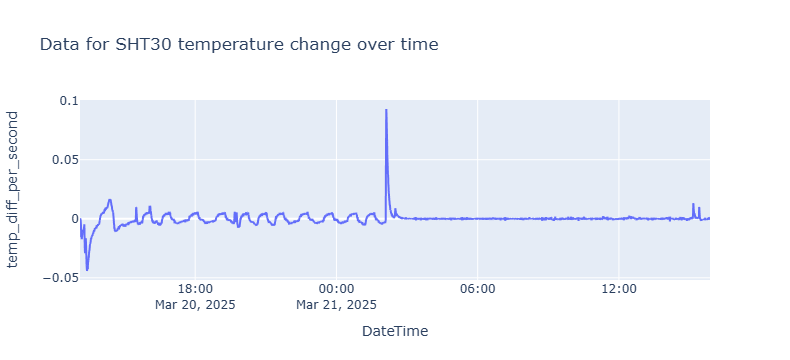

In [9]:
px.line(sht_df, x='DateTime', y='temp_diff_per_second', title=f'Data for SHT30 temperature change over time')

THE END - Why not try extending this notebook to plot both DS18b20 sensors on the same chart...